<a href="https://colab.research.google.com/github/clemsongreg/IST718/blob/main/Lab2/Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Taking It To The House

In [2]:
# Library Initialization

import pandas as pd
import numpy as np

import folium
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from warnings import catch_warnings
from warnings import filterwarnings

from datetime import timedelta

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data Preparation

In [3]:
# Download the csv file from the Zillow site.  
URL = 'https://files.zillowstatic.com/research/public/Zip/Zip_Zhvi_SingleFamilyResidence.csv'

# Create intial dataframe called coachesRaw
rawData = pd.read_csv(URL) 

In [4]:
# Quick look at the imported data
display(rawData.head(5))
display(rawData.dtypes)
display(rawData.shape)

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,...,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1524562.0,1525605.0,1525955.0,1528604.0,1527843.0,1530509.0,1525013.0,1531236.0,1532307.0,1543260.0,1534946.0,1527048.0,1508495.0,1498638.0,1494872.0,1487969.0,1480591.0,1471324.0,1462476.0,1456223.0,1448110.0,1446622.0,1451579.0,1452858.0,1453112.0,1439554.0,1426900.0,1416568.0,1415022.0,1414474.0,1413747.0,1405862.0,1402547.0,1390420.0,1381621.0,1375725.0,1374714.0,1381453.0,1385737.0,1389268.0
1,84654,1,60657,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,364892.0,364162.0,363605.0,362963.0,361660.0,361342.0,360662.0,361804.0,363561.0,366592.0,370077.0,372842.0,376806.0,380122.0,384081.0,385663.0,389062.0,389359.0,390182.0,388087.0,385729.0,381688.0,377848.0,376493.0,374914.0,375094.0,375012.0,378067.0,380789.0,386605.0,392801.0,...,958178.0,956528.0,951529.0,955244.0,958096.0,959882.0,958726.0,956879.0,958371.0,961171.0,960878.0,957985.0,958428.0,964051.0,969547.0,968807.0,968566.0,969572.0,972936.0,973010.0,972447.0,972684.0,975094.0,978629.0,981362.0,979667.0,976810.0,975419.0,975366.0,975741.0,974693.0,975616.0,975734.0,975251.0,974238.0,973104.0,971908.0,972038.0,973671.0,975642.0
2,61637,2,10023,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1669910.0,1661199.0,1639318.0,1622378.0,1613382.0,1611625.0,1609075.0,1611388.0,1615755.0,1619823.0,1609176.0,1597282.0,1581756.0,1572273.0,1573601.0,1578799.0,1585506.0,1587796.0,1591265.0,1596660.0,1598258.0,1596017.0,1595032.0,1592948.0,1590038.0,1576594.0,1562766.0,1552128.0,1545711.0,1540137.0,1528603.0,1514894.0,1502233.0,1492429.0,1486122.0,1480426.0,1476509.0,1478980.0,1479301.0,1474994.0
3,91982,3,77494,Zip,TX,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,200475.0,200723.0,200526.0,199337.0,198200.0,197534.0,198298.0,197986.0,197333.0,196543.0,197444.0,199129.0,201687.0,202931.0,204207.0,206413.0,208870.0,210582.0,210250.0,212394.0,214904.0,217109.0,216177.0,214468.0,211736.0,210126.0,208420.0,207481.0,206443.0,206033.0,205925.0,...,331031.0,330770.0,331485.0,332276.0,332365.0,331319.0,331016.0,331256.0,331356.0,331165.0,331177.0,331223.0,332171.0,333159.0,333470.0,333247.0,333699.0,334667.0,335386.0,335194.0,335478.0,335777.0,336150.0,336558.0,336390.0,336776.0,336806.0,336869.0,336217.0,335679.0,335536.0,335878.0,335940.0,336092.0,336119.0,336083.0,336154.0,335860.0,336037.0,336483.0
4,84616,4,60614,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,546663.0,546231.0,545451.0,545391.0,543066.0,543084.0,542380.0,545254.0,548142.0,552660.0,557791.0,562238.0,566446.0,569659.0,573409.0,575403.0,581567.0,584316.0,587753.0,585957.0,583932.0,580996.0,578241.0,578355.0,580711.0,585527.0,591659.0,597955.0,604759.0,611702.0,620591.0,...,1173759.0,1175981.0,1174668.0,1182530.0,1188431.0,1192806.0,1193344.0,1191314.0,1192626.0,1196983.0,1199400.0,1199387.0,1202485.0,120

RegionID        int64
SizeRank        int64
RegionName      int64
RegionType     object
StateName      object
               ...   
2019-11-30    float64
2019-12-31    float64
2020-01-31    float64
2020-02-29    float64
2020-03-31    float64
Length: 300, dtype: object

(30464, 300)

So each row contains data for a single zip code.  Information stored includes - Region ID, a "SizeRank", ZipCode, State/City location info, metro area (if any), county info, and then home value index as determined by Zillow from 1996 - 2020.  

Rows that are likely to not be useful for us include the ID, rank, and Type.  These columns will be removed for clarity.

In [5]:
unusedFlds = ['RegionID', 'SizeRank', 'RegionType']
zipData = rawData.drop(unusedFlds,1)
zipData.head()
colnames = []

# Change Zip Code name from 'RegionName' to 'ZipCode'
for x in zipData.columns:
  colnames.append(x)
colnames[0] = 'ZipCode'
zipData.columns = colnames

# Set Zip Code as df index
#zipData = zipData.set_index('ZipCode')
zipData['ZipCode'] = zipData['ZipCode'].astype('str')
zipData.head(5)

,ZipCode,StateName,State,City,Metro,CountyName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,1998-08-31,1998-09-30,1998-10-31,...,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31
0,10025,NY,NY,New York,New York-Newark-Jersey City,New York County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1524562.0,1525605.0,1525955.0,1528604.0,1527843.0,1530509.0,1525013.0,1531236.0,1532307.0,1543260.0,1534946.0,1527048.0,1508495.0,1498638.0,1494872.0,1487969.0,1480591.0,1471324.0,1462476.0,1456223.0,1448110.0,1446622.0,1451579.0,1452858.0,1453112.0,1439554.0,1426900.0,1416568.0,1415022.0,1414474.0,1413747.0,1405862.0,1402547.0,1390420.0,1381621.0,1375725.0,1374714.0,1381453.0,1385737.0,1389268.0
1,60657,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,364892.0,364162.0,363605.0,362963.0,361660.0,361342.0,360662.0,361804.0,363561.0,366592.0,370077.0,372842.0,376806.0,380122.0,384081.0,385663.0,389062.0,389359.0,390182.0,388087.0,385729.0,381688.0,377848.0,376493.0,374914.0,375094.0,375012.0,378067.0,380789.0,386605.0,392801.0,400292.0,408057.0,416827.0,...,958178.0,956528.0,951529.0,955244.0,958096.0,959882.0,958726.0,956879.0,958371.0,961171.0,960878.0,957985.0,958428.0,964051.0,969547.0,968807.0,968566.0,969572.0,972936.0,973010.0,972447.0,972684.0,975094.0,978629.0,981362.0,979667.0,976810.0,975419.0,975366.0,975741.0,974693.0,975616.0,975734.0,975251.0,974238.0,973104.0,971908.0,972038.0,973671.0,975642.0
2,10023,NY,NY,New York,New York-Newark-Jersey City,New York County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1669910.0,1661199.0,1639318.0,1622378.0,1613382.0,1611625.0,1609075.0,1611388.0,1615755.0,1619823.0,1609176.0,1597282.0,1581756.0,1572273.0,1573601.0,1578799.0,1585506.0,1587796.0,1591265.0,1596660.0,1598258.0,1596017.0,1595032.0,1592948.0,1590038.0,1576594.0,1562766.0,1552128.0,1545711.0,1540137.0,1528603.0,1514894.0,1502233.0,1492429.0,1486122.0,1480426.0,1476509.0,1478980.0,1479301.0,1474994.0
3,77494,TX,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,200475.0,200723.0,200526.0,199337.0,198200.0,197534.0,198298.0,197986.0,197333.0,196543.0,197444.0,199129.0,201687.0,202931.0,204207.0,206413.0,208870.0,210582.0,210250.0,212394.0,214904.0,217109.0,216177.0,214468.0,211736.0,210126.0,208420.0,207481.0,206443.0,206033.0,205925.0,204647.0,204133.0,204600.0,...,331031.0,330770.0,331485.0,332276.0,332365.0,331319.0,331016.0,331256.0,331356.0,331165.0,331177.0,331223.0,332171.0,333159.0,333470.0,333247.0,333699.0,334667.0,335386.0,335194.0,335478.0,335777.0,336150.0,336558.0,336390.0,336776.0,336806.0,336869.0,336217.0,335679.0,335536.0,335878.0,335940.0,336092.0,336119.0,336083.0,336154.0,335860.0,336037.0,336483.0
4,60614,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,546663.0,546231.0,545451.0,545391.0,543066.0,543084.0,542380.0,545254.0,548142.0,552660.0,557791.0,562238.0,566446.0,569659.0,573409.0,575403.0,581567.0,584316.0,587753.0,585957.0,583932.0,580996.0,578241.0,578355.0,580711.0,585527.0,591659.0,597955.0,604759.0,611702.0,620591.0,630536.0,643350.0,654584.0,...,1173759.0,1175981.0,1174668.0,1182530.0,1188431.0,1192806.0,1193344.0,1191314.0,1192626

## Data Exploration

### Quick Looks

Start by looking at aggregate data at the state level.

In [6]:
statelist = []
statelist = zipData['State'].unique()
len(statelist)

51

The dataset includes data for all 50 states, plus DC.  Let's look at the most recent housing prices as a median and mean for each state.  

In [7]:
stateAgg = pd.DataFrame()
statemedian = []
statemean= []

for state in statelist:
  statemean.append(round(np.mean(zipData[zipData['State'] == state]['2020-03-31']),0))
  statemedian.append(round(np.median(zipData[zipData['State'] == state]['2020-03-31'],0)))            

stateAgg['State'] = statelist
stateAgg['Mean'] = statemean
stateAgg['Median'] = statemedian


In [8]:
display(np.mean(zipData['2020-03-31']))
display(np.mean(statemean))


237898.1729582458

255030.25490196078

In [9]:
stateURL = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/us-states.json'

# Initialize the map:
m1 = folium.Map(location=[37, -102], zoom_start=5)

# Add the color for the chloropleth:
folium.Choropleth(
 geo_data=stateURL,
 name='choropleth',
 data=stateAgg,
 columns=['State', 'Mean'],
 key_on='id',
 fill_color='BuGn',
 fill_opacity=0.7,
 legend = 'Average of Median Prices by Zip Code').add_to(m1)

m1

In [10]:
# Initialize the map:
m2 = folium.Map(location=[37, -102], zoom_start=5)

# Add the color for the chloropleth:
folium.Choropleth(
 geo_data=stateURL,
 name='choropleth',
 data=stateAgg,
 columns=['State', 'Median'],
 key_on='id',
 fill_color='BuGn',
 fill_opacity=0.7,
 legend = 'Median of Housing Prices by Zip Code').add_to(m2)

m2

It's interesting that for some states, there is quite a disparity between the mean and the median housing values.  Places like New York State for example - a very high mean average, but a relatively low median average.  This suggests there are some very high priced neighborhoods (likely New York City area), while the rest of the state is less expensive overall.  

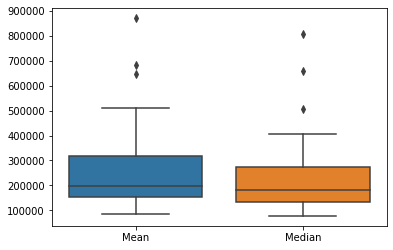

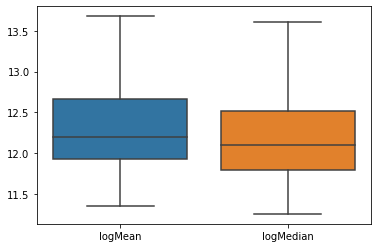

In [11]:
stateAgg['Diff'] = stateAgg['Median'] - stateAgg['Mean']

g1 = sns.boxplot(data=stateAgg[['Mean', 'Median']])
plt.show(g1)

stateAgg['logMean'] = np.log(stateAgg['Mean'])
stateAgg['logMedian'] = np.log(stateAgg['Median'])

g2 = sns.boxplot(data=stateAgg[['logMean', 'logMedian']])
plt.show(g2)


In [12]:
stateAgg=stateAgg.sort_values(by= ['Diff'])
display(stateAgg.head(5))
display(stateAgg.tail(5))

,State,Mean,Median,Diff,logMean,logMedian
3,CA,683189.0,508291,-174898.0,13.434527,13.138809
0,NY,349670.0,182641,-167029.0,12.764745,12.115278
17,MA,509817.0,406448,-103369.0,13.141807,12.915211
7,DC,870494.0,806434,-64060.0,13.676816,13.600377
12,NJ,407795.0,347220,-60575.0,12.918520,12.757714


,State,Mean,Median,Diff,logMean,logMedian
42,WV,85219.0,77528,-7691.0,11.352980,11.258394
48,AK,272375.0,265924,-6451.0,12.514935,12.490966
31,ND,157604.0,152294,-5310.0,11.967841,11.933568
43,SD,173958.0,170172,-3786.0,12.066569,12.044565
38,HI,644918.0,658659,13741.0,13.376878,13.397961


Unsurprisingly the states with the biggest difference in Mean and Median are states with large urban areas - California, NY, Massachusets, DC, and New Jersey.  What is MORE surprising is the other end - with a mean that is LOWER than the median, Hawaii is the only state that is opposite, suggesting that the outliers here for property values are on the LOW end of the spectrum..   

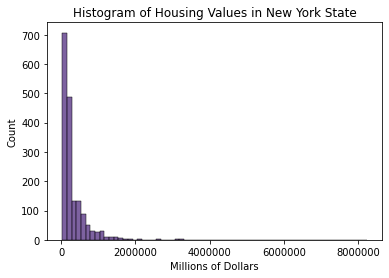

In [13]:
nydata = zipData[zipData['State'] == 'NY']
p4 = sns.histplot(nydata['2020-03-31'], bins=65, color = '#522D80')
p4.get_xaxis().get_major_formatter().set_scientific(False)
plt.title('Histogram of Housing Values in New York State')
plt.xlabel('Millions of Dollars')
plt.show()

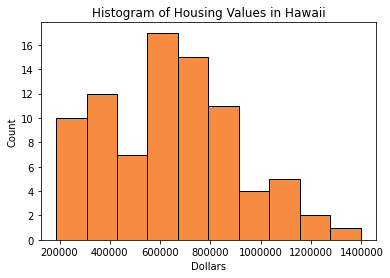

In [14]:
hidata = zipData[zipData['State'] == 'HI']
p4 = sns.histplot(hidata['2020-03-31'], bins=10, color = '#F56600')
p4.get_xaxis().get_major_formatter().set_scientific(False)
plt.title('Histogram of Housing Values in Hawaii')
plt.xlabel('Dollars')
plt.show()

### What about Arkansas?

Let's look at data from Arkansas and how property values have changed for the following areas:

• Hot Springs, Little Rock, Fayetteville, Searcy

To do this, we will take the mean home value for all zip codes in each metro area.

In [15]:
# List of the metro areas to investigate
arMetro = ['Hot Springs', 'Little Rock', 'Fayetteville', 'Searcy']

In [16]:
# Create a new dataframe called arkag - housing the aggregate values for each month for each metro area
arkag = pd.DataFrame()

# For each metro area, create a Series aggregating by mean.  This takes the mean of all zipcodes in the metro area
# (that are also in Arkansas..) and adds it as a new column in the arkag dataframe
for metro in arMetro:
  metdf = zipData[(zipData['Metro'].str.contains(metro, na = False)) & (zipData['State'] == 'AR')]
  m1 = metdf.agg(func = "mean")
  arkag[metro] = m1

# Remove the ZipCode row in the dataframe, which was also aggregated and voila, aggregate data for each 
# metro area, ready for graphing.
arkag = arkag[arkag.index != 'ZipCode']
arkag['Date'] = pd.to_datetime(arkag.index)
arkag= arkag.set_index('Date')
display(arkag.head(5))



,Hot Springs,Little Rock,Fayetteville,Searcy
Date,,,,
1996-01-31,78546.8,84050.083333,93923.137931,56772.416667
1996-02-29,77961.6,84245.125000,93050.700000,56666.000000
1996-03-31,77987.0,84856.102041,93128.100000,56678.666667
1996-04-30,78008.4,85225.836735,93273.733333,56677.500000
1996-05-31,78266.4,85586.387755,93489.100000,56733.750000


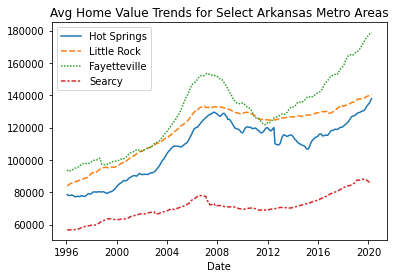

In [17]:
# Plot the Metro areas against each other
t1 = sns.lineplot(data = arkag)
plt.title('Avg Home Value Trends for Select Arkansas Metro Areas')

plt.show(t1)

I don't know much about Fayetteville, Arkansas, but looking at the trend over the last decade, it seems to be a pretty popular place!

Outside of that, the housing crisis of 2008 is clearly visible, with a prominent bubble in the Fayetteville data that collapses down through ~ 2010/2011 before recovering steadily since.

## Time Series Modeling

### First steps

The first step in time series modeling is to look at some sample data and see how far from stationary it is, and if further transformation will be required.  Let's start with the second record (record 1), as it is the first row of complete data.

We'll need to make a new df with the row, melt it, and then look at autocorrelation

In [18]:
# Pull the data for a single zipcode for initial testing.  For this, we will use zip code 60657
sampdf = zipData[zipData['ZipCode'] == '60657']

meltcols = zipData.columns[6:]
sampmelt = sampdf.melt(id_vars = 'ZipCode', value_vars = meltcols, var_name='Date')
sampmelt['Date'] = pd.to_datetime(sampmelt['Date'])
sampmelt = sampmelt.drop('ZipCode', axis = 1)
sampmelt.head()

,Date,value
0,1996-01-31,364892.0
1,1996-02-29,364162.0
2,1996-03-31,363605.0
3,1996-04-30,362963.0
4,1996-05-31,361660.0


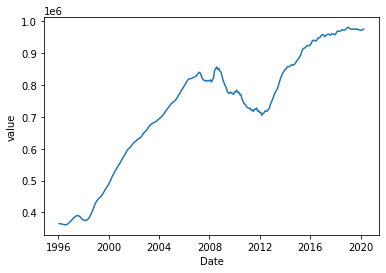

In [19]:
p1 = sns.lineplot(data = sampmelt, x='Date', y='value')
plt.show(p1)

The home values move from ~ 350k in 1996 to nearly 1 million in 2020..  Not exactly stationary..  This is probably going to take some work..

In [20]:
result = adfuller(sampmelt['value'], autolag='AIC')

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.971406
p-value: 0.299250
Critical Values:
	1%: -3.454
	5%: -2.872
	10%: -2.572


Yeah, we're gonna need some work.. 

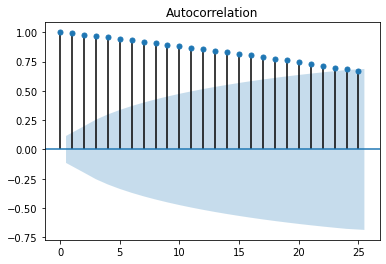

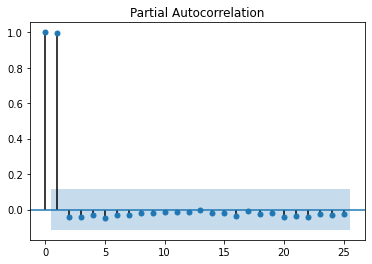

In [21]:
plot_acf(sampmelt['value'], ax=plt.gca())
plt.show()

#pyplot.subplot(212)

plot_pacf(sampmelt['value'], ax=plt.gca())
plt.show()

### Model Evaluation

For our model I want to use an exponential smoothing technique to forecast future property values.  There are a few ways to implement this, so I want to test on the single subset of data to see which model yields the best AIC/BIC values, and use that model across the whole dataset.

Want to see which type of exponential smoothing model best fits the data

In [22]:
sampdf = zipData[zipData['ZipCode'] == '29501']
meltcols = zipData.columns[6:]
sampmelt = sampdf.melt(id_vars = 'ZipCode', value_vars = meltcols, var_name='Date')
sampmelt['Date'] = pd.to_datetime(sampmelt['Date'])
sampmelt = sampmelt.drop('ZipCode', axis = 1)

sampmelt.shape
samptrain = sampmelt.iloc[0:243]
samptest = sampmelt.iloc[243:]
samptrain = samptrain.dropna()

  # There are 3 sets of knobs to test in the Exponential Smoothing model - Trend type (None, additive, multiplicative),
  # seasonality (None, additive, multiplicative - for this test seasonality is determined at an annual basis), and
  # whether to include a damped component or not.  All in all - 18 test models.
  
t_param = ['add', 'mul']
s_param = [None, 'add', 'mul']
d_param = [True, False]
resultdict = {}
modnum = 1

mod = ExponentialSmoothing(np.asarray(samptrain['value']), trend = 'add', seasonal_periods=12, seasonal= None, damped=True)
fit = mod.fit()
rmse = mean_squared_error(samptrain['value'], fit.fittedvalues, squared = False)
display(rmse)
       # pred = fit.forecast(48)
        #if np.isnan(pred[0]) == False:
         
          #resultdict[modnum] = [t, s, d, fit.bic, rmse]
        #modnum += 1

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


336.1456141653979

In [23]:
''' Writing a procedure to do a step-wise run through exponential smoothing models and returns the model with the lowest
AIC.  It also returns the conditions used to get that model '''

def modeltest(df, zip) :
  sampdf = df[df['ZipCode'] == zip]
  meltcols = df.columns[6:]
  sampmelt = sampdf.melt(id_vars = 'ZipCode', value_vars = meltcols, var_name='Date')
  sampmelt['Date'] = pd.to_datetime(sampmelt['Date'])
  sampmelt = sampmelt.drop('ZipCode', axis = 1)

  sampmelt.shape
  samptrain = sampmelt.iloc[0:243]
  samptest = sampmelt.iloc[243:]
  samptrain = samptrain.dropna()

  # There are 3 sets of knobs to test in the Exponential Smoothing model - Trend type (None, additive, multiplicative),
  # seasonality (None, additive, multiplicative - for this test seasonality is determined at an annual basis), and
  # whether to include a damped component or not.  All in all - 18 test models.
  
  t_param = ['add', 'mul']
  s_param = [None, 'add', 'mul']
  d_param = [True, False]
  resultdict = {}
  modnum = 1

  for d in d_param:
    for s in s_param:
      for t in t_param:
        filterwarnings('ignore')
        mod = ExponentialSmoothing(np.asarray(samptrain['value']), trend = t,  damped=d, seasonal_periods=12, seasonal = s)
        fit = mod.fit()
        pred = fit.forecast(48)
        if np.isnan(pred[0]) == False:
          rmse = mean_squared_error(samptest['value'], pred, squared = False)
          resultdict[modnum] = [t, s, d, fit.aic, rmse]
        modnum += 1
  
  resultdf = pd.DataFrame.from_dict(resultdict, orient = 'index', columns = ['Trend', 'Seasonality', 'Damped', 'AIC', 'RMSE'])
  print("Top 3 By AIC")
  display(resultdf.sort_values(by="AIC", ascending = True).head(3))
  print ("Top 3 By RMSE of predictions")
  display(resultdf.sort_values(by="RMSE", ascending=True).head(3))
    
  
  
  

In [24]:
def modelPlot (df, zip, t, d):
  sampdf = df[df['ZipCode'] == zip]
  meltcols = df.columns[6:]
  sampmelt = sampdf.melt(id_vars = 'ZipCode', value_vars = meltcols, var_name='Date')
  sampmelt['Date'] = pd.to_datetime(sampmelt['Date'])
  sampmelt = sampmelt.drop('ZipCode', axis = 1)

  sampmelt.shape
  samptrain = sampmelt.iloc[0:243]
  samptest = sampmelt.iloc[243:]
  samptrain = samptrain.dropna()

  mod = ExponentialSmoothing(np.asarray(samptrain['value']), trend = t, damped= d)
  fit = mod.fit()
  pred = fit.forecast(48)
  samptest['pred'] = pred

  p2 = sns.lineplot(data= samptest.set_index('Date'))
  plt.title(zip)
  plt.setp(p2.get_xticklabels(), rotation=45)
  p2.get_yaxis().get_major_formatter().set_scientific(False)
  plt.show()


First test - the Chicago area zip code looked at above

In [25]:
modeltest(df = zipData, zip = '60657')

Top 3 By AIC


,Trend,Seasonality,Damped,AIC,RMSE
2,mul,None,True,3995.599403,10968.870724
1,add,None,True,3995.654722,10275.180917
7,add,None,False,4006.711319,106169.122722


Top 3 By RMSE of predictions


,Trend,Seasonality,Damped,AIC,RMSE
3,add,add,True,4037.753957,9482.158456
1,add,None,True,3995.654722,10275.180917
2,mul,None,True,3995.599403,10968.870724


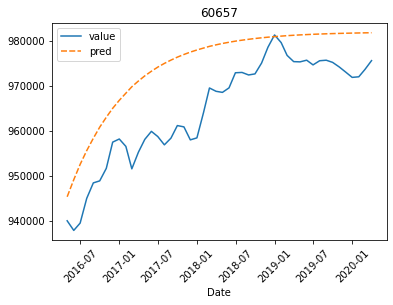

In [26]:
modelPlot(df = zipData, zip = '60657', t='mul', d=True)

Second test is a bit closer to home - my personal zip code which I know is not seeing the sort of growth seen in other places.

In [27]:
modeltest(df = zipData, zip = '29501')

Top 3 By AIC


,Trend,Seasonality,Damped,AIC,RMSE
2,mul,None,True,2045.455092,6282.027460
1,add,None,True,2046.140555,6152.246700
7,add,None,False,2060.302016,10957.436217


Top 3 By RMSE of predictions


,Trend,Seasonality,Damped,AIC,RMSE
3,add,add,True,2238.548052,3029.296335
12,mul,mul,False,2278.219608,3635.651565
9,add,add,False,2240.731409,3934.212754


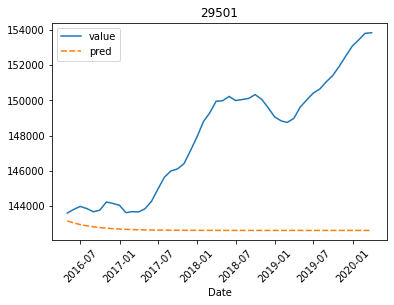

In [28]:
modelPlot(df = zipData, zip = '29501', t='mul', d=True)

Finally, a zip code of in-laws in a fairly trendy suburb of Buffalo, NY.

In [29]:
modeltest(df=zipData, zip = '14031')

Top 3 By AIC


,Trend,Seasonality,Damped,AIC,RMSE
2,mul,None,True,3129.692098,27581.417777
1,add,None,True,3130.127271,27585.421306
7,add,None,False,3154.285734,18941.506614


Top 3 By RMSE of predictions


,Trend,Seasonality,Damped,AIC,RMSE
11,add,mul,False,3196.892650,17936.812058
8,mul,None,False,3155.679736,18939.979284
7,add,None,False,3154.285734,18941.506614


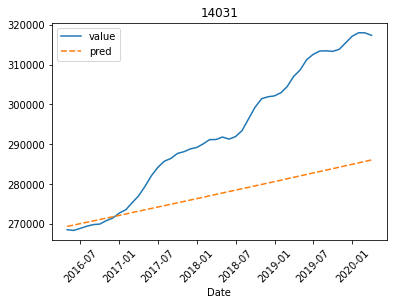

In [30]:
modelPlot(df=zipData, zip = '14031', t='mul', d=False)

In all 3 tests, model 2 - a multiplicative trend with the damping factor added - does the best, extremely well in fact with data like the Chicago model.  Though it doesn't predict the rising prices in my own hometown, the damping effect does keep the model from predicting fire-sale levels of dropping home prices, which is what is predicted by other smoothing models.

The model does seem to have trouble with the Buffalo suburb, which is seeing booming prices.  This is somewhat troubling.  The model may not be so good at predicting recent popularity booms.  Or perhaps the surging prices in this zip code are a potential bubble that should be avoided...

It's worth noting that in almost all cases, lower values for RMSE on the forecasted values could be found using different models with seasonal effects.  The trouble is, these values all had much higher AIC numbers, suggesting there is good evidence the models are not accurate predictors.  And honestly, it defeats given the unknowable nature of the future, I really feel better relying on strong AIC numbers, so I choose to use it as my decision point for model.

To help speed up model evaluation, however, I note that no seasonality seems to be present in the best AIC-value models.  I will allow for potential for additive trends, and for the exclusion of the damping effect, but will remove the seasonality check for the main data.

### Expanding the Model Everywhere

The meat of the problem - how to apply this model to every zip code in the database and return results.  As mentioned above, we will do a modified step-wise search, picking the best model based on AIC.  The model will return forecast values out 60 months, as well as the RMSE for the fitted model values.  This is to help determine confidence in the model's accuracy, hopefully.



Trial 1 - Let's build a model function and run it on 50 zipcodes and see how the returns look.

In [31]:
def pricepredict (data):
  finaldf = pd.DataFrame()
  for zip in data['ZipCode']:
   tdf = data[data['ZipCode'] == zip]
   meltcols = data.columns[6:]
   tmelt = tdf.melt(id_vars = 'ZipCode', value_vars = meltcols, var_name='Date')
   tmelt['Date'] = pd.to_datetime(tmelt['Date'])
   tmelt = tmelt.drop('ZipCode', axis = 1)
   tmelt = tmelt.dropna()
 
   t_param = ['add', 'mul']
   d_param = [True, False]
   resultdict = {}
   modnum = 1

   for d in d_param:
    for t in t_param:
     filterwarnings('ignore')
     mod = ExponentialSmoothing(np.asarray(tmelt['value']), trend = t,  damped=d)
     fit = mod.fit()
     pred = fit.forecast(60)
     if np.isnan(pred[0]) == False:
       rmse = mean_squared_error(tmelt['value'], fit.fittedvalues, squared = False)
       resultdict[modnum] = [zip, tmelt['value'].iloc[-1], t, d, fit.aic, rmse, round(pred[11], 0), round(pred[35], 0), round(pred[59],0)]
    modnum += 1
    resultdf = pd.DataFrame.from_dict(resultdict, orient = 'index', columns = ['Zip Code', 'Last Actual Value', 'Trend', 'Damping', 'AIC', 'RMSE', '1-Year Value', '3-Year Value', '5-Year Value'])
   finaldf = finaldf.append(resultdf.sort_values(by='AIC', ascending = True).head(1), ignore_index=True)
  return finaldf    

In [32]:
firstzips = pricepredict(zipData.iloc[0:50])
display(firstzips.tail(10))

,Zip Code,Last Actual Value,Trend,Damping,AIC,RMSE,1-Year Value,3-Year Value,5-Year Value
40,94565,587011.0,mul,True,2159.061909,2862.608499,596099.0,596674.0,596676.0
41,37042,157378.0,mul,True,3012.183266,173.884362,176174.0,192724.0,197509.0
42,11206,1140120.0,mul,True,4755.934971,3479.094863,1186725.0,1193594.0,1193707.0
43,73099,177643.0,mul,True,3512.725476,410.932371,181432.0,181984.0,181993.0
44,90046,1900980.0,mul,True,4646.196199,2881.230823,2072060.0,2210816.0,2247093.0
45,20009,1053737.0,mul,True,4492.314492,2211.820680,1046899.0,1044635.0,1044479.0
46,77429,259878.0,mul,True,3433.996308,358.939973,267126.0,269581.0,269751.0
47,78245,189599.0,mul,True,3292.605294,281.523319,193836.0,195266.0,195366.0
48,77479,379569.0,mul,True,3713.123142,579.841355,381978.0,382755.0,382806.0
49,10462,545216.0,mul,True,4420.343906,1954.540667,524327.0,520282.0,520169.0


The model looks good.  Results look to be in order.  Time to run the whole shebang.  To do this, the zip code database will be broken into 5,000 zip code chunks and processed.  Then, the dataframes returned will be converted to CSV's, merged together, downloaded and then later sent to Github for further processing.

In [33]:
a=5000
b=10000
c=15000
d=20000
e=25000
f=len(zipData)
predictdf = pd.DataFrame()

In [34]:
# Hashed out b/c unneeded after getting csv's
#from google.colab import drive
#drive.mount('drive')

In [35]:
# The following blocks make and send the csv's for the 30k zip codes.  Hashed out to prevent long unneeded running
#adf = pricepredict(zipData.iloc[0:a])
#adf.to_csv('groupAzips.csv')
#!cp groupAzips.csv "drive/My Drive/"

In [36]:
#bdf = pricepredict(zipData.iloc[a:b])
#bdf.to_csv('groupBzips.csv')
#!cp groupBzips.csv "drive/My Drive/"

In [37]:
#cdf = pricepredict(zipData.iloc[b:c])
#cdf.to_csv('groupCzips.csv')
#!cp groupCzips.csv "drive/My Drive/"

In [38]:
#ddf = pricepredict(zipData.iloc[c:d])
#ddf.to_csv('groupDzips.csv')
#!cp groupDzips.csv "drive/My Drive/"

In [39]:
#edf = pricepredict(zipData.iloc[d:e])
#edf.to_csv('groupEzips.csv')
#!cp groupEzips.csv "drive/My Drive/"

In [40]:
#fdf = pricepredict(zipData.iloc[e:f])
#fdf.to_csv('groupFzips.csv')
#!cp groupFzips.csv "drive/My Drive/"

## Finding the Best Deals

### We're Bringing Data Back

Now we can finally start to dig into the zip codes and look for ideal candidates.  The first step in this process is to bring back in all 6 csv's of model data (which are now available on my Github), confirm the zips are all there, and do a quick exploration of the data.

In [41]:
modeldf = pd.DataFrame()
urllist = ['https://raw.githubusercontent.com/clemsongreg/IST718/main/Lab2/groupAzips.csv',
           'https://raw.githubusercontent.com/clemsongreg/IST718/main/Lab2/groupBzips.csv',
           'https://raw.githubusercontent.com/clemsongreg/IST718/main/Lab2/groupCzips.csv',
           'https://raw.githubusercontent.com/clemsongreg/IST718/main/Lab2/groupDzips.csv',
           'https://raw.githubusercontent.com/clemsongreg/IST718/main/Lab2/groupEzips.csv',
           'https://raw.githubusercontent.com/clemsongreg/IST718/main/Lab2/groupFzips.csv']

In [42]:
for url in urllist:
  tempdf = pd.read_csv(url)
  display(tempdf.shape)
  modeldf = modeldf.append(tempdf, ignore_index=True)
display(modeldf.shape)

(5000, 10)

(5000, 10)

(5000, 10)

(5000, 10)

(5000, 10)

(5464, 10)

(30464, 10)

In [43]:
modeldf['Zip Code'] = modeldf['Zip Code'].astype('str')


In [44]:
modeldf = modeldf.iloc[:,1:]
display(modeldf.head(5))
display(modeldf.describe())



,Zip Code,Last Actual Value,Trend,Damping,AIC,RMSE,1-Year Value,3-Year Value,5-Year Value
0,10025,1389268.0,mul,True,3682.597415,10174.416840,1401882.0,1402683.0,1402686.0
1,60657,975642.0,mul,True,4764.642690,3531.539446,984495.0,986194.0,986238.0
2,10023,1474994.0,mul,True,2359.459849,8403.335890,1463307.0,1463001.0,1463001.0
3,77494,336483.0,mul,True,3744.812013,612.288007,338569.0,338870.0,338875.0
4,60614,1200980.0,mul,True,4899.054311,4449.010363,1209584.0,1212693.0,1212932.0


,Last Actual Value,AIC,RMSE,1-Year Value,3-Year Value,5-Year Value
count,3.046400e+04,30464.000000,30464.000000,3.046400e+04,3.046400e+04,3.046400e+04
mean,2.378982e+05,2798.885315,713.967380,2.437766e+05,2.480953e+05,2.510676e+05
std,2.801460e+05,1089.866520,1024.671365,2.917477e+05,3.035848e+05,3.160236e+05
min,1.149200e+04,165.336876,16.603061,1.193000e+04,1.019300e+04,5.787000e+03
25%,1.064082e+05,1971.015649,306.301804,1.075752e+05,1.080368e+05,1.081668e+05
50%,1.660700e+05,3024.104377,479.767442,1.686715e+05,1.700680e+05,1.708260e+05
75%,2.702558e+05,3684.368311,792.410441,2.763285e+05,2.814845e+05,2.842118e+05
max,8.221444e+06,6031.313994,48254.567030,8.046650e+06,8.835801e+06,1.123726e+07


In [45]:
# Curious as to how the variables shook out.
trend = modeldf['Trend'].unique()
damp = modeldf['Damping'].unique()
#print('Trend types used: ')
print('# of Zipcodes Using Multiplicative model: ', str(modeldf[modeldf['Trend'] == 'mul']['Zip Code'].count()))
print('# of Zipcodes Using Damping constant: ', str(modeldf[modeldf['Damping'] == True]['Zip Code'].count()))

# of Zipcodes Using Multiplicative model:  30464
# of Zipcodes Using Damping constant:  29213


So all models used the multiplicative trend - meaning we could have seriously shortened our model building time..  ON the other hand, most (but by no means all) of the models used a Damping constant.  I'm curious what that means for those that did not..

### Decision Points

There are 2 basic criteria I thought to use for deciding zip codes for investment.  

First is a risk factor - how trustworthy is the model and therefore its predictions.  To determine this, I chose to engineer a feature based on the RMSE as a percent of the Last Actual Value.  I recognize this is probably not great data science, but I struggled to find a useable method to measure uncertainty using the exponential smoothing model.  

The second factor is the investment's return - specifically its Net Present Value (NPV) at 3 points, considered (for the purpose of this excercise) as a short-term (1 year), medium (3 years), and long-term (5 years) investment.  Obviously 5 years for a real estate holding is far from a long-term investment, but just go with me..  To calculate NPV, I am using a base discount rate of 8%.  Therefore, the returned number says - this is how much the investment is worth in today's (well, March 2020) dollars.  If the number is positive, that means the investment is better than simply putting the money in a safe 8% investment.  If negative, well, you might have been better off investing that money elsewhere.

In [46]:
# The first feature adding is a percentage - the RMSE divided by the Last Actual Value.  My thinking is, a model with a high % would have
# a high error (and therefore worse fit) to the data, making it's predictions less trustworthy.  I recognize however, that a model with a very low
# error to value might simply be way too overfit and still not trustworthy.  This may or may not be useful but let's see.

modeldf['ErrPct'] = round(modeldf['RMSE'] / modeldf['Last Actual Value'], 4)
display(modeldf.sort_values('ErrPct', ascending = True).head(5))



,Zip Code,Last Actual Value,Trend,Damping,AIC,RMSE,1-Year Value,3-Year Value,5-Year Value,ErrPct
26112,56734,48862.0,mul,False,165.336876,16.603061,51477.0,57134.0,63413.0,0.0003
19520,39347,121529.0,mul,False,205.528528,44.639786,121565.0,121637.0,121709.0,0.0004
5529,47546,179265.0,mul,False,1811.633469,84.982637,183642.0,192719.0,202245.0,0.0005
11395,25661,42480.0,mul,False,193.243557,19.841968,43133.0,44466.0,45840.0,0.0005
16848,99929,229120.0,mul,False,260.491961,107.315925,248232.0,291388.0,342046.0,0.0005


In [47]:
# Columns for NPV at 1, 3, and 5-year holds, less the initial value.

modeldf['1YrNPV'] = round(np.npv(0.08, [0, modeldf['1-Year Value']]) - modeldf['Last Actual Value'],0)
modeldf['3YrNPV'] = round(np.npv(0.08, [0, 0, 0, modeldf['3-Year Value']]) - modeldf['Last Actual Value'],0)
modeldf['5YrNPV'] = round(np.npv(0.08, [0, 0, 0, 0, 0,  modeldf['5-Year Value']]) - modeldf['Last Actual Value'],0)
modeldf.head(5)

,Zip Code,Last Actual Value,Trend,Damping,AIC,RMSE,1-Year Value,3-Year Value,5-Year Value,ErrPct,1YrNPV,3YrNPV,5YrNPV
0,10025,1389268.0,mul,True,3682.597415,10174.416840,1401882.0,1402683.0,1402686.0,0.0073,-91229.0,-275773.0,-434623.0
1,60657,975642.0,mul,True,4764.642690,3531.539446,984495.0,986194.0,986238.0,0.0036,-64073.0,-192769.0,-304425.0
2,10023,1474994.0,mul,True,2359.459849,8403.335890,1463307.0,1463001.0,1463001.0,0.0057,-120080.0,-313617.0,-479300.0
3,77494,336483.0,mul,True,3744.812013,612.288007,338569.0,338870.0,338875.0,0.0018,-22993.0,-67477.0,-105850.0
4,60614,1200980.0,mul,True,4899.054311,4449.010363,1209584.0,1212693.0,1212932.0,0.0037,-80995.0,-238305.0,-375479.0


In [48]:
democols = ['ZipCode', 'StateName', 'State', 'City', 'Metro', 'CountyName']
demodf = zipData[democols]
modeldf = pd.merge(demodf, modeldf, left_on = 'ZipCode', right_on = 'Zip Code')


In [49]:
def makepredict (zip):
  topflip = zipData[zipData['ZipCode'] == zip]
  meltcols = zipData.columns[6:]
  topmelt = topflip.melt(id_vars = 'ZipCode', value_vars = meltcols, var_name='Date')
  topmelt['Date'] = pd.to_datetime(topmelt['Date'])
  topmelt = topmelt.drop('ZipCode', axis = 1)
  topmelt['Type'] = 'Actual'
  topmelt = topmelt.dropna()

  lastdate = topmelt['Date'].iloc[-1]
  datelist = []
  n = 0
  while n < 60: 
    lastdate += timedelta(days=30)
    datelist.append(lastdate)
    n += 1

  t= modeldf[modeldf['ZipCode'] == '61332']['Trend'].values[0]
  d = modeldf[modeldf['ZipCode'] == '61332'].loc[:]['Damping'].values[0]
  mod1 = ExponentialSmoothing(topmelt['value'], trend = t, damped = d)
  fit1 = mod1.fit()
  pred1 = fit1.forecast(60).values
  preddf = pd.DataFrame()
  preddf['Date'] = datelist
  preddf['value'] = pred1
  preddf['Type'] = 'prediction'
  topmelt = topmelt.append(preddf, ignore_index = True)

  p3 = sns.lineplot(data = topmelt[topmelt['Date'] > '2015-01-01'], x='Date', y='value', style='Type', hue = 'Type')
  plt.title(zip)
  p3.get_yaxis().get_major_formatter().set_scientific(False)
  plt.show()
 

### Flippy-Floppys

Where are the best deals to be found for house flippers?  That is, homes in zip codes with the highest potential NPV after 1 year?  Because everything is coming up Los Angeles, I also adjusted this to a percentage of the initial house cost.  I thought this might help make areas with less pricey housing, but with larger growth potential, stand out.

I also split into 2 groups.  Those where the model included a damping constant and those where it didn't.  Becuase I found those where the damping constant was turned off, things went..  Wild..  And that might be good for risk-takers, but less so for cautious choosers.

In [50]:
modeldf['1YrNPVPct'] = round(modeldf['1YrNPV'] / modeldf['Last Actual Value'] * 100, 1)

In [51]:
cautiousflips = modeldf[modeldf['Damping'] == True].sort_values('1YrNPVPct', ascending = False).head(10)
display(cautiousflips)

,ZipCode,StateName,State,City,Metro,CountyName,Zip Code,Last Actual Value,Trend,Damping,AIC,RMSE,1-Year Value,3-Year Value,5-Year Value,ErrPct,1YrNPV,3YrNPV,5YrNPV,1YrNPVPct
29525,61332,IL,IL,Tonica,Ottawa-Peru,La Salle County,61332,64735.0,mul,True,1335.762990,392.252342,84778.0,92733.0,93311.0,0.0061,13763.0,8879.0,-1229.0,21.3
9981,90211,CA,CA,Beverly Hills,Los Angeles-Long Beach-Anaheim,Los Angeles County,90211,2544209.0,mul,True,4814.593015,3848.021728,3244536.0,4476456.0,5376523.0,0.0015,459991.0,1009346.0,1114962.0,18.1
27811,45033,OH,OH,Cleves,Cincinnati,Hamilton County,45033,72809.0,mul,True,1096.208821,478.971468,92548.0,100267.0,100825.0,0.0066,12884.0,6786.0,-4189.0,17.7
2352,32404,FL,FL,Panama City,Panama City,Bay County,32404,182082.0,mul,True,3698.044131,565.011218,227867.0,272401.0,286015.0,0.0031,28906.0,34159.0,12575.0,15.9
17067,93283,CA,CA,Weldon,Bakersfield,Kern County,93283,135857.0,mul,True,2239.009361,523.879791,166073.0,179552.0,180805.0,0.0039,17914.0,6677.0,-12804.0,13.2
2137,19132,PA,PA,Philadelphia,Philadelphia-Camden-Wilmington,Philadelphia County,19132,48757.0,mul,True,3174.161744,229.683903,59543.0,61274.0,61302.0,0.0047,6375.0,-116.0,-7036.0,13.1
28992,95417,CA,CA,Branscomb,Ukiah,Mendocino County,95417,321676.0,mul,True,1563.274914,2026.555265,390626.0,413537.0,414866.0,0.0063,40015.0,6603.0,-39325.0,12.4
2628,90007,CA,CA,Los Angeles,Los Angeles-Long Beach-Anaheim,Los Angeles County,90007,804835.0,mul,True,4406.747370,1909.408420,975850.0,1137795.0,1186534.0,0.0024,98730.0,98383.0,2700.0,12.3
7145,90304,CA,CA,Inglewood,Los Angeles-Long Beach-Anaheim,Los Angeles County,90304,592151.0,mul,True,4232.853634,1416.242133,716166.0,914100.0,1044051.0,0.0024,70966.0,133491.0,118413.0,12.0
5107,43607,OH,OH,Toledo,Toledo,Lucas County,43607,40061.0,mul,True,3142.636030,217.573372,48349.0,51469.0,51692.0,0.0054,4707.0,797.0,-4880.0,11.7


Looking at this list, my top 3 picks for Short Term investment opportunities would be zipcodes:
19132 - Philadelphia metro
43607 - Toledo, OH area
93283 - Weldon, CA

These areas predict decent growth in the coming year or 2, but panning out after that.  These could be good for getting in, making a flip, and getting back out before the market peaks for a bit.

These 3 also have reasonable RMSE versus home value suggesting a pretty good model fit as evidence.

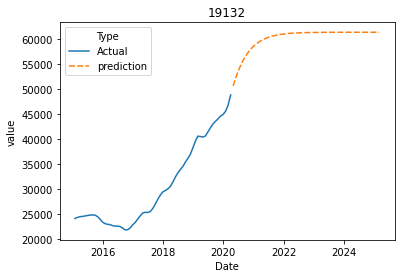

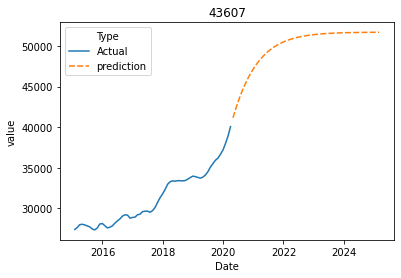

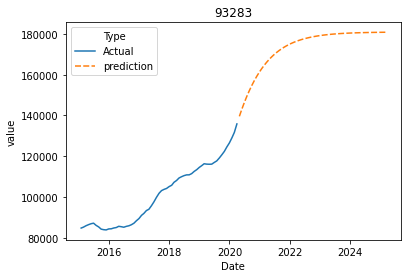

In [52]:
makepredict('19132')
makepredict('43607')
makepredict('93283')


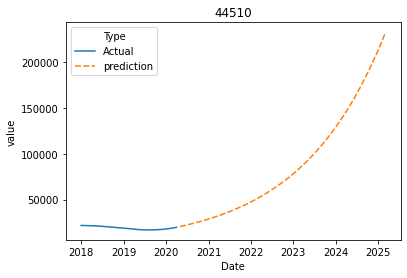

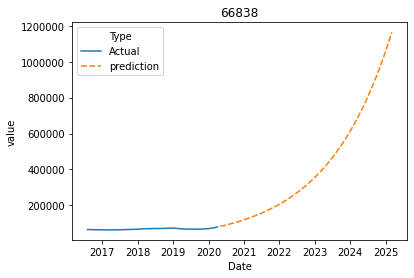

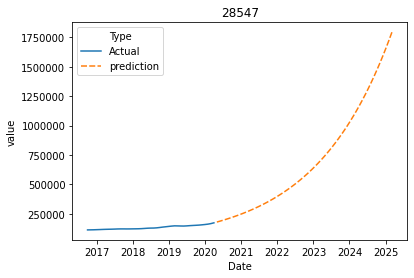

In [61]:
makepredict('44510')
makepredict('66838')
makepredict('28547')

When you have a little money, and you're willing to take a risk - take a look at these 3 hotspots..  Sure the maps say there isn't much here, but who knows - when everyone else is snapping up those houses around Camp Lejeune next year, you'll be sitting pretty..

### 3-Year Itch

In [54]:
modeldf['3YrNPVPct'] = round(modeldf['3YrNPV'] / modeldf['Last Actual Value'] * 100, 1)

In [55]:
cautious3rds = modeldf[modeldf['Damping'] == True].sort_values('3YrNPVPct', ascending = False).head(10)
display(cautious3rds)

,ZipCode,StateName,State,City,Metro,CountyName,Zip Code,Last Actual Value,Trend,Damping,AIC,RMSE,1-Year Value,3-Year Value,5-Year Value,ErrPct,1YrNPV,3YrNPV,5YrNPV,1YrNPVPct,3YrNPVPct
9981,90211,CA,CA,Beverly Hills,Los Angeles-Long Beach-Anaheim,Los Angeles County,90211,2544209.0,mul,True,4814.593015,3848.021728,3244536.0,4476456.0,5376523.0,0.0015,459991.0,1009346.0,1114962.0,18.1,39.7
7145,90304,CA,CA,Inglewood,Los Angeles-Long Beach-Anaheim,Los Angeles County,90304,592151.0,mul,True,4232.853634,1416.242133,716166.0,914100.0,1044051.0,0.0024,70966.0,133491.0,118413.0,12.0,22.5
2352,32404,FL,FL,Panama City,Panama City,Bay County,32404,182082.0,mul,True,3698.044131,565.011218,227867.0,272401.0,286015.0,0.0031,28906.0,34159.0,12575.0,15.9,18.8
5308,90210,CA,CA,Beverly Hills,Los Angeles-Long Beach-Anaheim,Los Angeles County,90210,5902641.0,mul,True,5283.547973,8613.439466,7101068.0,8835801.0,9824952.0,0.0015,672422.0,1111503.0,784056.0,11.4,18.8
2331,90403,CA,CA,Santa Monica,Los Angeles-Long Beach-Anaheim,Los Angeles County,90403,2628604.0,mul,True,4733.122496,3345.363875,3126072.0,3900755.0,4397549.0,0.0013,265907.0,467941.0,364294.0,10.1,17.8
9349,91108,CA,CA,San Marino,Los Angeles-Long Beach-Anaheim,Los Angeles County,91108,2352497.0,mul,True,4588.200966,2607.962863,2749065.0,3466891.0,4050322.0,0.0011,192934.0,399633.0,404084.0,8.2,17.0
1783,91605,CA,CA,Los Angeles,Los Angeles-Long Beach-Anaheim,Los Angeles County,91605,635235.0,mul,True,4127.860027,1182.470144,748540.0,918785.0,1022973.0,0.0019,57858.0,94126.0,60983.0,9.1,14.8
2251,90266,CA,CA,Manhattan Beach,Los Angeles-Long Beach-Anaheim,Los Angeles County,90266,2685710.0,mul,True,4688.739267,3099.731906,3137144.0,3879077.0,4401025.0,0.0012,219053.0,393626.0,309554.0,8.2,14.7
29525,61332,IL,IL,Tonica,Ottawa-Peru,La Salle County,61332,64735.0,mul,True,1335.762990,392.252342,84778.0,92733.0,93311.0,0.0061,13763.0,8879.0,-1229.0,21.3,13.7
2628,90007,CA,CA,Los Angeles,Los Angeles-Long Beach-Anaheim,Los Angeles County,90007,804835.0,mul,True,4406.747370,1909.408420,975850.0,1137795.0,1186534.0,0.0024,98730.0,98383.0,2700.0,12.3,12.2


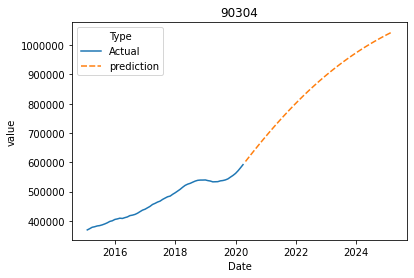

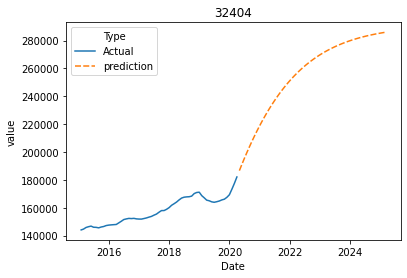

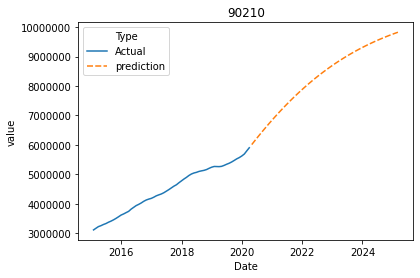

In [56]:
makepredict('90304')
makepredict('32404')
makepredict('90210')

We are starting to see Los Angeles become the real estate epicenter here at the 3-year mark.  For many zip codes, while the models predict strong NPV's through 5-years, it's really at the 3-year mark that those investments are maximized.  This is obviously doubly true if you consider all the property tax you are likely paying on these ridiculously priced houses..

An interesting prediction here is across the country, in Panama Beach.  This zipcode is a bit rural, outside of Panama Beach proper.  Ther model predicts a bit of a price surge in recent years.  This seems plausible, as Florida cities continue to stretch into the Glades, and snowbirds continue to retire and flock to the sunny shores. This seems like an ideal investment potential, though as the model shows, there is a limited upside - knowing when to hold and when to fold is key here..

### In for the Long Haul

In [57]:
modeldf['5YrNPVPct'] = round(modeldf['5YrNPV'] / modeldf['Last Actual Value'] * 100, 1)

In [58]:
longcons = modeldf[modeldf['Damping'] == True].sort_values('5YrNPVPct', ascending = False).head(10)
display(longcons)

,ZipCode,StateName,State,City,Metro,CountyName,Zip Code,Last Actual Value,Trend,Damping,AIC,RMSE,1-Year Value,3-Year Value,5-Year Value,ErrPct,1YrNPV,3YrNPV,5YrNPV,1YrNPVPct,3YrNPVPct,5YrNPVPct
9981,90211,CA,CA,Beverly Hills,Los Angeles-Long Beach-Anaheim,Los Angeles County,90211,2544209.0,mul,True,4814.593015,3848.021728,3244536.0,4476456.0,5376523.0,0.0015,459991.0,1009346.0,1114962.0,18.1,39.7,43.8
7145,90304,CA,CA,Inglewood,Los Angeles-Long Beach-Anaheim,Los Angeles County,90304,592151.0,mul,True,4232.853634,1416.242133,716166.0,914100.0,1044051.0,0.0024,70966.0,133491.0,118413.0,12.0,22.5,20.0
9349,91108,CA,CA,San Marino,Los Angeles-Long Beach-Anaheim,Los Angeles County,91108,2352497.0,mul,True,4588.200966,2607.962863,2749065.0,3466891.0,4050322.0,0.0011,192934.0,399633.0,404084.0,8.2,17.0,17.2
2331,90403,CA,CA,Santa Monica,Los Angeles-Long Beach-Anaheim,Los Angeles County,90403,2628604.0,mul,True,4733.122496,3345.363875,3126072.0,3900755.0,4397549.0,0.0013,265907.0,467941.0,364294.0,10.1,17.8,13.9
5308,90210,CA,CA,Beverly Hills,Los Angeles-Long Beach-Anaheim,Los Angeles County,90210,5902641.0,mul,True,5283.547973,8613.439466,7101068.0,8835801.0,9824952.0,0.0015,672422.0,1111503.0,784056.0,11.4,18.8,13.3
2251,90266,CA,CA,Manhattan Beach,Los Angeles-Long Beach-Anaheim,Los Angeles County,90266,2685710.0,mul,True,4688.739267,3099.731906,3137144.0,3879077.0,4401025.0,0.0012,219053.0,393626.0,309554.0,8.2,14.7,11.5
1783,91605,CA,CA,Los Angeles,Los Angeles-Long Beach-Anaheim,Los Angeles County,91605,635235.0,mul,True,4127.860027,1182.470144,748540.0,918785.0,1022973.0,0.0019,57858.0,94126.0,60983.0,9.1,14.8,9.6
2352,32404,FL,FL,Panama City,Panama City,Bay County,32404,182082.0,mul,True,3698.044131,565.011218,227867.0,272401.0,286015.0,0.0031,28906.0,34159.0,12575.0,15.9,18.8,6.9
115,90044,CA,CA,Los Angeles,Los Angeles-Long Beach-Anaheim,Los Angeles County,90044,491153.0,mul,True,4000.167900,949.521897,565567.0,681908.0,758720.0,0.0019,32520.0,50168.0,25219.0,6.6,10.2,5.1
4467,91030,CA,CA,South Pasadena,Los Angeles-Long Beach-Anaheim,Los Angeles County,91030,1336877.0,mul,True,4353.831350,1743.461439,1531625.0,1844894.0,2061383.0,0.0013,81294.0,127659.0,66066.0,6.1,9.5,4.9


Dealers choice here really.  Take a look at anywhere in LA County, pray the state doesn't slide into the ocean in the next 5 years, and profit.

In [59]:
crazies = modeldf[modeldf['Damping'] == False].sort_values('5YrNPVPct', ascending = False).head(10)
display(crazies)

,ZipCode,StateName,State,City,Metro,CountyName,Zip Code,Last Actual Value,Trend,Damping,AIC,RMSE,1-Year Value,3-Year Value,5-Year Value,ErrPct,1YrNPV,3YrNPV,5YrNPV,1YrNPVPct,3YrNPVPct,5YrNPVPct
29180,66838,KS,KS,Burdick,NaN,Morris County,66838,79208.0,mul,False,551.031724,417.250109,135591.0,397335.0,1164346.0,0.0053,46339.0,236209.0,713226.0,58.5,298.2,900.4
17663,44510,OH,OH,Youngstown,Youngstown-Warren-Boardman,Mahoning County,44510,19635.0,mul,False,249.369892,74.453640,32202.0,86611.0,232951.0,0.0038,10182.0,49120.0,138908.0,51.9,250.2,707.5
19186,35061,AL,AL,Birmingham,Birmingham-Hoover,Jefferson County,35061,61318.0,mul,False,975.848755,317.667264,99068.0,258597.0,675016.0,0.0052,30412.0,143965.0,398087.0,49.6,234.8,649.2
24915,78549,TX,TX,Hargill,McAllen-Edinburg-Mission,Hidalgo County,78549,63982.0,mul,False,376.075854,314.563266,103364.0,269769.0,704067.0,0.0049,31725.0,150169.0,415194.0,49.6,234.7,648.9
10537,28547,NC,NC,Dunn,Dunn,Harnett County,28547,173052.0,mul,False,579.710009,771.078978,276227.0,703794.0,1793183.0,0.0045,82714.0,385642.0,1047358.0,47.8,222.8,605.2
15186,87013,NM,NM,Cuba,Albuquerque,Sandoval County,87013,189190.0,mul,False,610.314237,1100.647496,285584.0,650737.0,1482781.0,0.0058,75240.0,327386.0,819966.0,39.8,173.0,433.4
28489,79777,TX,TX,Pyote,NaN,Ward County,79777,57419.0,mul,False,487.532039,301.483338,86283.0,194834.0,439952.0,0.0053,22473.0,97247.0,242005.0,39.1,169.4,421.5
26636,63941,MO,MO,Fremont,NaN,Carter County,63941,101201.0,mul,False,422.762082,374.343039,150664.0,333934.0,740136.0,0.0037,38303.0,163887.0,402523.0,37.8,161.9,397.7
26461,95419,CA,CA,Occidental,Santa Rosa,Sonoma County,95419,393903.0,mul,False,715.285124,2181.748244,581255.0,1265676.0,2755994.0,0.0055,144296.0,610831.0,1481780.0,36.6,155.1,376.2
27932,66962,KS,KS,Palmer,NaN,Washington County,66962,69927.0,mul,False,441.882653,351.876090,101322.0,212727.0,446623.0,0.0050,23890.0,98943.0,234037.0,34.2,141.5,334.7


In [60]:
crazyflips = modeldf[modeldf['Damping'] == False ].sort_values('5YrNPVPct', ascending = False).head(10)
display(crazyflips)

,ZipCode,StateName,State,City,Metro,CountyName,Zip Code,Last Actual Value,Trend,Damping,AIC,RMSE,1-Year Value,3-Year Value,5-Year Value,ErrPct,1YrNPV,3YrNPV,5YrNPV,1YrNPVPct,3YrNPVPct,5YrNPVPct
29180,66838,KS,KS,Burdick,NaN,Morris County,66838,79208.0,mul,False,551.031724,417.250109,135591.0,397335.0,1164346.0,0.0053,46339.0,236209.0,713226.0,58.5,298.2,900.4
17663,44510,OH,OH,Youngstown,Youngstown-Warren-Boardman,Mahoning County,44510,19635.0,mul,False,249.369892,74.453640,32202.0,86611.0,232951.0,0.0038,10182.0,49120.0,138908.0,51.9,250.2,707.5
19186,35061,AL,AL,Birmingham,Birmingham-Hoover,Jefferson County,35061,61318.0,mul,False,975.848755,317.667264,99068.0,258597.0,675016.0,0.0052,30412.0,143965.0,398087.0,49.6,234.8,649.2
24915,78549,TX,TX,Hargill,McAllen-Edinburg-Mission,Hidalgo County,78549,63982.0,mul,False,376.075854,314.563266,103364.0,269769.0,704067.0,0.0049,31725.0,150169.0,415194.0,49.6,234.7,648.9
10537,28547,NC,NC,Dunn,Dunn,Harnett County,28547,173052.0,mul,False,579.710009,771.078978,276227.0,703794.0,1793183.0,0.0045,82714.0,385642.0,1047358.0,47.8,222.8,605.2
15186,87013,NM,NM,Cuba,Albuquerque,Sandoval County,87013,189190.0,mul,False,610.314237,1100.647496,285584.0,650737.0,1482781.0,0.0058,75240.0,327386.0,819966.0,39.8,173.0,433.4
28489,79777,TX,TX,Pyote,NaN,Ward County,79777,57419.0,mul,False,487.532039,301.483338,86283.0,194834.0,439952.0,0.0053,22473.0,97247.0,242005.0,39.1,169.4,421.5
26636,63941,MO,MO,Fremont,NaN,Carter County,63941,101201.0,mul,False,422.762082,374.343039,150664.0,333934.0,740136.0,0.0037,38303.0,163887.0,402523.0,37.8,161.9,397.7
26461,95419,CA,CA,Occidental,Santa Rosa,Sonoma County,95419,393903.0,mul,False,715.285124,2181.748244,581255.0,1265676.0,2755994.0,0.0055,144296.0,610831.0,1481780.0,36.6,155.1,376.2
27932,66962,KS,KS,Palmer,NaN,Washington County,66962,69927.0,mul,False,441.882653,351.876090,101322.0,212727.0,446623.0,0.0050,23890.0,98943.0,234037.0,34.2,141.5,334.7
